In [38]:
from typing import List, Tuple, Iterable
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit import opflow
from qiskit.opflow.primitive_ops import PauliSumOp

In [2]:
def ising_hamiltonian(pauli_list: List[Tuple[str, float]]) -> PauliSumOp:
    return PauliSumOp.from_list(pauli_list)

def get_thermal_state(H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
    H = H.mul(-1 * beta) # returns -beta*H
    exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
    partition_function = np.trace(exp_H)
    return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

-1.0 * ZZ
- 1.0 * IZ
+ 1.0 * ZI


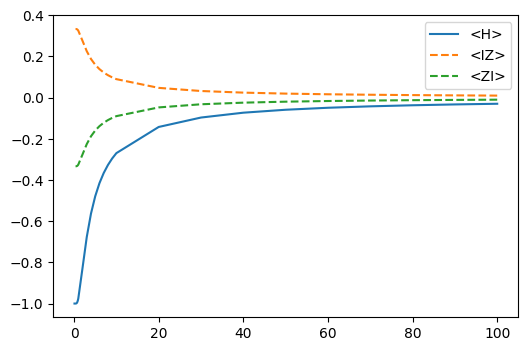

In [3]:
temp_range = list(np.arange(100, 1, -10)) + list(np.arange(9,0,-1)) + list(np.arange(0.9, 0, -0.1))

pauli_list = [('ZZ', -1), ('IZ', -1), ('ZI', 1)]
H = ising_hamiltonian(pauli_list)
print(H)
energy = []
avg_mag = []
for t in temp_range:
    beta = 1/t    
    rho = get_thermal_state(H, beta)
    energy.append(rho.expectation_value(H).real)
    spin0 = rho.expectation_value(PauliSumOp.from_list([('IZ', 1)])).real
    spin1 = rho.expectation_value(PauliSumOp.from_list([('ZI', 1)])).real
    avg_mag.append((spin0, spin1))
    
fig, ax = plt.subplots(dpi=100)
ax.plot(temp_range, energy, label='<H>')
ax.plot(temp_range, [m[0] for m in avg_mag], ls='--', label='<IZ>')
ax.plot(temp_range, [m[1] for m in avg_mag], ls='--', label='<ZI>')
ax.legend()

In [100]:
class QuantumBoltzmannMachine:
    def __init__(self, graph: nx.Graph, visible_nodes: List[int], hidden_nodes: List[int]) -> None:
        '''
        Implementation of a Quantum Boltzmann Machine based on the papers:
        
        (1) Quantum Boltzmann Machine, 
            Mohammad H. Amin, Evgeny Andriyash, Jason Rolfe, Bohdan Kulchytskyy, and Roger Melko
            PRX 8, 021050 (2018). https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021050
        
        (2) A quantum algorithm to train neural netowrks using low-depth circuits,
            Guillaume Verdon, Michael Broughton, Jacob Biamonte
            arXiv:1712.05304v2. https://arxiv.org/abs/1712.05304
            
        The input graph determines the model structure. Currently, only restricted BMs are supported,
        i.e., edges should only exist between visible and hidden nodes.
        
        "states" are represented as tuples of binary values, however we use binary values of +1 and -1
        to match the quantum notation. example_state = (1, -1, -1, 1, ...)
        Additionally, the states are LITTLE ENDIAN ordered, meaning that for a state:
            (1, -1, 1) the visible node assignments are (v_2 = 1, v_1 = -1, v_0 = 1)
        '''
        self.graph = graph
        self.num_units = len(list(self.graph.nodes))
        
        # Check valid input
        for i, j in zip(sorted(visible_nodes + hidden_nodes), range(self.num_units)):
            if i != j:
                raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        if len(visible_nodes) + len(hidden_nodes) != self.num_units:
            raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        for v1, v2 in self.graph.edges:
            if (v1 in hidden_nodes and v2 in hidden_nodes) or (v1 in visible_nodes and v2 in visible_nodes):
                raise ValueError("Only Restricted Boltzmann Machines are currently supported")
        
        # Nodes are mapped to qubits: node_0 = qubit_0, node_1 = qubit_1, ...
        # States are always given in little endian order: z = (q_n-1, q_n-2, ..., q_2, q_1, q_0)
        self.visible_nodes = visible_nodes # [v_0, v_1, v_2] -> v = (v_2, v_1, v_0)
        self.hidden_nodes = hidden_nodes
        self.visible_node_map = {node: index for index, node in enumerate(self.visible_nodes)}
        
        # Parameter initialization
        # Mapping is done Index <-> Node
        self.single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(self.num_units)])
        # Mapping is done with edges between nodes, but always sorted low -> high
        self.double_params = {tuple(sorted(edge)): np.random.uniform(low=-1.0, high=1.0) for edge in self.graph.edges}
    
    
    def _gen_states(self, n: int) -> List[Tuple[int]]:
        """
        Generate all binary states with length n
        """
        bitstrings = []
        for i in range(int(2**n)):
            bitstrings.append(f'{i:0{n}b}')
            
        states = []
        for bitstr in bitstrings:
            state = [1 if b == '0' else -1 for b in bitstr]
            states.append(tuple(state))
        
        return states
    
    
    def get_hamiltonian(self, clamped: bool = False) -> PauliSumOp:
        """
        Construct a qiskit PauliSumOp that resprents the QBM Hamiltonian
        (Eq. 16 of Amin et al.)
        """
        pauli_list = []
        
        # single terms
        for node, param in enumerate(self.single_params):
            if clamped and node in self.visible_nodes:
                continue
            pauli = ['I'] * self.num_units
            pauli[node] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        # double terms
        for edge in self.graph.edges():
            if clamped and edge[0] in self.visible_nodes and edge[1] in self.visible_nodes:
                continue
            param = self.double_params[tuple(sorted(edge))]
            pauli = ['I'] * self.num_units
            pauli[edge[0]] = 'Z'
            pauli[edge[1]] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        return PauliSumOp.from_list(pauli_list)


    def get_thermal_state(self, H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
        """
        Generate a density matrix for a thermal state for the given Hamiltonian and temperature.
        
            rho = exp(-beta * H) / Tr[exp(-beta * H)]
            
        beta = 1 / T
        """
        H = H.mul(-1 * beta)
        exp_H = scipy.linalg.expm(H.to_matrix())
        partition_function = np.trace(exp_H)
        return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)
    
    
    def get_distribution(self, beta: float) -> dict:
        """
        Return the distribution over the visible states described by
        the current model parameters.
        
        The probability of observing a visible state, v, is given by
        Eq. 13 of Amin et al. (PRX version)
        
            P_v = Tr[Lambda_v * rho]
        """
        # Get all possible visible and total states
        #    gen_states returns the states in order: 0, 1, 2, 3, ...
        visible_states = self._gen_states(len(self.visible_nodes))
        all_states = self._gen_states(self.num_units)
        
        # Get the current thermal state described by the QBM
        rho = self.get_thermal_state(self.get_hamiltonian(), beta)
        
        probability_dist = {}
        for visible_state in visible_states:
            # Construct the projector matrix that will project rho onto the
            # states with the correct visible state
            projector = []
            for i, total_state in enumerate(all_states):
                row = np.zeros(int(2**self.num_units)) # Constructing an exponentially large matrix...
                cur_vis_state = [list(reversed(total_state))[j] for j in self.visible_nodes] # index into the REVERSED tuple to get the correct ordering
                cur_vis_state = tuple(reversed(cur_vis_state)) # reverse ordering to get (v_n-1, ..., v_2, v_1, v_0)
                if cur_vis_state == visible_state:
                    row[i] = 1
                projector.append(row)

            projector = qiskit.quantum_info.Operator(np.array(projector))
            probability_dist[visible_state] = np.trace(projector.dot(rho))
        
        return probability_dist
    
    
    def log_likelihood(self, data_dist: dict, model_dist: dict) -> float:
        """
        A well trained QBM minimizes the KL-divergence between the data and model probability distributions.
        
            KL(P_data || P_model) = Sum_v( P_v_data * log(P_v_data / P_v_model) )
            
        Since P_v_data is a constant, minimizing the KL divergence is equivalent to maximizing the average log-likelihood.
        Or, minimizing the average negative log-likelihood (Eq. 3 and 17 of Amin et al.)
        
            average_negative_log_likelihood = - Sum_v( P_v_data * log(P_v_model))
        """
        visible_states = self._gen_states(len(self.visible_nodes))
        
        log_likelihood = 0.0
        for visible_state in visible_states:
            p_v_data = data_dist.get(visible_state, 0)
            p_v_model = model_dist.get(visible_state, 0)
            if p_v_model > 0:
                log_likelihood -= p_v_data * np.log(p_v_model)
        
        return log_likelihood
    
    
    def plot_dist(self, model_dist: dict, data_dist: dict = None) -> None:
        fig, ax = plt.subplots(figsize=[15,5])
        xvals, yvals = [], []
        for key, val in model_dist.items():
            bitstring = ''.join(['0' if b == 1 else '1' for b in key])
            xvals.append(int(bitstring, 2))
            yvals.append(val)
            
        width = 0.4
        
        ax.bar(xvals, yvals, color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
        
        if data_dist is not None:
            data_xvals, data_yvals = [], []
            for key, val in data_dist.items():
                bitstring = ''.join(['0' if b == 1 else '1' for b in key])
                data_xvals.append(int(bitstring, 2))
                data_yvals.append(val)
            ax.bar(data_xvals, data_yvals, color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)
            
        plt.grid(alpha=.4, linestyle='--')
        plt.legend(fontsize=14)
        plt.xlabel(r'Visible state', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.show()
        plt.close()
        

    def compute_clamped_expectation(self, node: int, visible_state: Tuple[int]) -> float:
        # Eq 34 of Amin et al.
        terms = []
        for j, v_j in enumerate(reversed(visible_state)):
            visible_node_j = self.visible_nodes[j]
            terms.append(self.double_params.get(tuple(sorted((node, visible_node_j))), 0) * v_j)
        b_i_eff = self.single_params[node] + sum(terms)
        D_i = np.sqrt(b_i_eff**2) # modify this when updating the Hamiltonian to actually be quantum
        return (b_i_eff / D_i) * np.tanh(D_i)
    
    
    def exact_optimization(self, data_dist: dict, step_size: float = 0.1, cutoff: float = 1e-3,
                           max_epoch: int = 100, verbose: int = 0, beta: float = 10.0) -> None:
        cur_epoch = 1
        progress = 100
        cur_log_likelihood = self.log_likelihood(data_dist, self.get_distribution(beta))
        while progress > cutoff and cur_epoch <= max_epoch:
            # Get clamped and unclamped Hamiltonians
            unclamped_hamiltonian = self.get_hamiltonian(clamped=False)
            #clamped_hamiltonian   = self.get_hamiltonian(clamped=True)
            
            # Get their respective low-temperature thermal states
            unclamped_rho = self.get_thermal_state(unclamped_hamiltonian, beta)
            #clamped_rho = self.get_thermal_state(clamped_hamiltonian, beta)
            
            # Update parameters, Theta(n) -> Theta(n+1)
            new_single_params = copy.copy(self.single_params)
            new_double_params = copy.copy(self.double_params)
            
            # First, update the single parameters 
            single_param_deltas = []
            for i in range(len(self.single_params)):
                # positive phase, <z_i>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if i in self.visible_nodes:
                        expectation = list(reversed(visible_state))[self.visible_node_map[i]]
                    else:
                        expectation = self.compute_clamped_expectation(i, visible_state)
                    positive_phase += p_v_data * expectation # Eq. 29 of Amin et al.
                
                # negative phase, <z_i> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[i] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_single_params[i] += step_size * (positive_phase - negative_phase) # Eq. 30 of Amin et al.
                
            # Second, update the double parameters
            for edge in self.double_params.keys():
                # positive phase, <z_i*z_j>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if edge[0] in self.visible_nodes:
                        expectation = list(reversed(visible_state))[self.visible_node_map[edge[0]]] * self.compute_clamped_expectation(edge[1], visible_state)
                    elif edge[1] in self.visible_nodes:
                        expectation = list(reversed(visible_state))[self.visible_node_map[edge[1]]] * self.compute_clamped_expectation(edge[0], visible_state)
                    else:
                        raise Exception('Something went wrong, expected an RBM graph structure')
                    positive_phase += p_v_data * expectation
                
                # negative phase, <z_i*z_j> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[edge[0]] = 'Z'
                paulistr[edge[1]] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_double_params[edge] += step_size * (positive_phase - negative_phase) # Eq. 31 of Amin et al.
                
            # Perform the update
            self.single_params = new_single_params
            self.double_params = new_double_params
            
            new_log_likelihood = self.log_likelihood(data_dist, self.get_distribution(beta))
            progress = abs(new_log_likelihood - cur_log_likelihood)
            
            if verbose > 0 and (cur_epoch-1) % 20 == 0:
                print(f'Finished epoch {cur_epoch}:')
                print(f'\t|L_i - L_i+1| = |{cur_log_likelihood:.5f} - {new_log_likelihood:.5f}| = {progress:.5f}')
            
            cur_log_likelihood = new_log_likelihood
            
            cur_epoch += 1

[0, 1] [2, 3, 4]
[ 0.62410975  0.26573121 -0.83215259 -0.51235306 -0.84367272]
{(0, 2): 0.032678839373877056, (0, 3): -0.3272995318181404, (0, 4): -0.6224554326040648, (1, 2): -0.7131339595534965, (1, 3): 0.7840320153726814, (1, 4): -0.983083194515032}
0.8321525881676846 * IIZII
+ 0.5123530580193052 * IZIII
+ 0.8436727178717713 * ZIIII
- 0.032678839373877056 * IIZIZ
+ 0.3272995318181404 * IZIIZ
+ 0.6224554326040648 * ZIIIZ
+ 0.7131339595534965 * IIZZI
- 0.7840320153726814 * IZIZI
+ 0.983083194515032 * ZIIZI


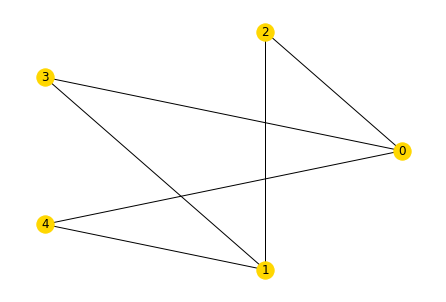

In [141]:
G = nx.Graph()
G.add_edges_from([(0,2), (0,3), (0,4),
                  (1,2), (1,3), (1,4)])
nx.draw_circular(G, with_labels=True, node_color='gold')

visible = [0,1]
hidden = [2, 3, 4]
bm = QuantumBoltzmannMachine(G, visible, hidden)
print(bm.visible_nodes, bm.hidden_nodes)
print(bm.single_params)
print(bm.double_params)
print(bm.get_hamiltonian(clamped=True))

(0.9999999999999999+0j)
Log likelihood: L(data, model) = 198.981+0.000j


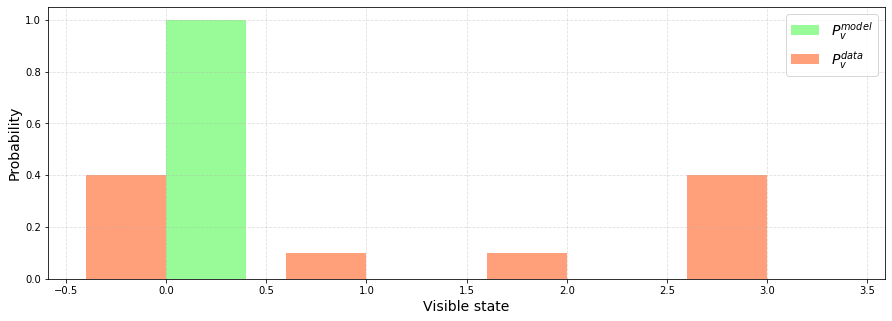

In [144]:
data_dist = {(-1, -1): 0.40, (-1, 1): 0.1, (1, -1): 0.1, (1, 1): 0.4}
beta = 100

model_dist = bm.get_distribution(beta=beta)
print(sum(model_dist.values()))
llh = bm.log_likelihood(data_dist, model_dist)
print(f'Log likelihood: L(data, model) = {llh:.3f}')
bm.plot_dist(model_dist, data_dist=data_dist)

Finished epoch 1:
	|L_i - L_i+1| = |1.19939+0.00000j - 1.19939+0.00000j| = 0.00000
Finished epoch 21:
	|L_i - L_i+1| = |1.19940+0.00000j - 1.19940+0.00000j| = 0.00000
Finished epoch 41:
	|L_i - L_i+1| = |1.19942+0.00000j - 1.19942+0.00000j| = 0.00000
Finished epoch 61:
	|L_i - L_i+1| = |1.19943+0.00000j - 1.19943+0.00000j| = 0.00000
Finished epoch 81:
	|L_i - L_i+1| = |1.19944+0.00000j - 1.19944+0.00000j| = 0.00000
Finished epoch 101:
	|L_i - L_i+1| = |1.19946+0.00000j - 1.19946+0.00000j| = 0.00000
Finished epoch 121:
	|L_i - L_i+1| = |1.19947+0.00000j - 1.19947+0.00000j| = 0.00000
Finished epoch 141:
	|L_i - L_i+1| = |1.19948+0.00000j - 1.19948+0.00000j| = 0.00000
Finished epoch 161:
	|L_i - L_i+1| = |1.19950+0.00000j - 1.19950+0.00000j| = 0.00000
Finished epoch 181:
	|L_i - L_i+1| = |1.19951+0.00000j - 1.19951+0.00000j| = 0.00000
Finished epoch 201:
	|L_i - L_i+1| = |1.19952+0.00000j - 1.19952+0.00000j| = 0.00000
Finished epoch 221:
	|L_i - L_i+1| = |1.19954+0.00000j - 1.19954+0.0000

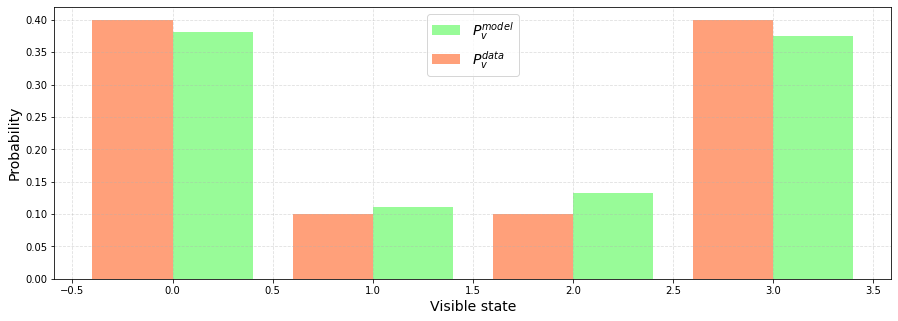

In [146]:
step_size = 0.0001
cutoff = 1e-7
max_epoch = 500

bm.exact_optimization(data_dist, step_size=step_size, cutoff=cutoff, max_epoch=max_epoch, verbose=1,
                      beta=beta)
print('\nFinal Distribution:\n')
bm.plot_dist(bm.get_distribution(beta), data_dist=data_dist)